# Metadata

```yaml
Course:   DS 5001
Module:   08a 
Topic:    How to Compare Topic Models (Gensim)
Author:   Gensim (adapted by R.C. Alvarado
Date:     23 March 2023
```

**Purpose:** Demonstrates how you can visualize and compare trained topic models.




# Set Up

## Config

In [1]:
num_topics = 15

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py

In [3]:
from string import punctuation
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

# Acquire and Prepare Data

Acquire and clean up the 20 Newsgroups dataset.

In [4]:
newsgroups = fetch_20newsgroups()
eng_stopwords = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\s+', gaps=True)
stemmer = PorterStemmer()
translate_tab = {ord(p): u" " for p in punctuation}

Convert a documents to list of tokens.

In [5]:
def text2tokens(raw_text):
    """Split the raw_text string into a list of stemmed tokens."""
    clean_text = raw_text.lower().translate(translate_tab)
    tokens = [token.strip() for token in tokenizer.tokenize(clean_text)]
    tokens = [token for token in tokens if token not in eng_stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return [token for token in stemmed_tokens if len(token) > 2]  # skip short tokens

In [6]:
dataset = [text2tokens(txt) for txt in newsgroups['data']] 

Create Gensim dictionary.

In [7]:
dictionary = Dictionary(documents=dataset, prune_at=None)
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n=None)  # use Dictionary to remove un-relevant tokens
dictionary.compactify()

Convert list of tokens to bag of word representation

In [8]:
d2b_dataset = [dictionary.doc2bow(doc) for doc in dataset] 

# Fit LDA Models

In [9]:
lda_fst = LdaMulticore(
    corpus=d2b_dataset, 
    num_topics=num_topics, 
    id2word=dictionary,
    workers=4, 
    eval_every=None, 
    passes=10, 
    batch=True,
)

lda_snd = LdaMulticore(
    corpus=d2b_dataset, 
    num_topics=num_topics, 
    id2word=dictionary,
    workers=4, 
    eval_every=None, 
    passes=20, 
    batch=True,
)

# Visualize Differences with `diff()`

We use two slightly different visualization methods depending on how you're running this tutorial.

In [20]:
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models. Uses plotly as the backend."""
    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [21]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)

In [22]:
# py.init_notebook_mode()
plot_difference = plot_difference_plotly

Gensim can help you visualise the differences between topics. For this purpose, you can use the ``diff()`` method of LdaModel.

``diff()`` returns a matrix with distances **mdiff** and a matrix with annotations **annotation**. Read the docstring for more detailed info.

In each **mdiff[i][j]** cell you'll find a distance between **topic_i** from the first model and **topic_j** from the second model.

In each **annotation[i][j]** cell you'll find **[tokens from intersection, tokens from difference** between **topic_i** from first model and **topic_j** from the second model.




In [31]:
# print(LdaMulticore.diff.__doc__)

## Case 1: How topics within ONE model correlate with each other.

Short description:

* x-axis - topic1
* y-axis - topic2
* BLUE: strongly decorrelated topics
* RED: strongly correlated topics

In an ideal world, we would like to see different topics decorrelated between themselves.

In this case, our matrix would look like this:

In [24]:
mdiff = np.ones((num_topics, num_topics))
np.fill_diagonal(mdiff, 0.)

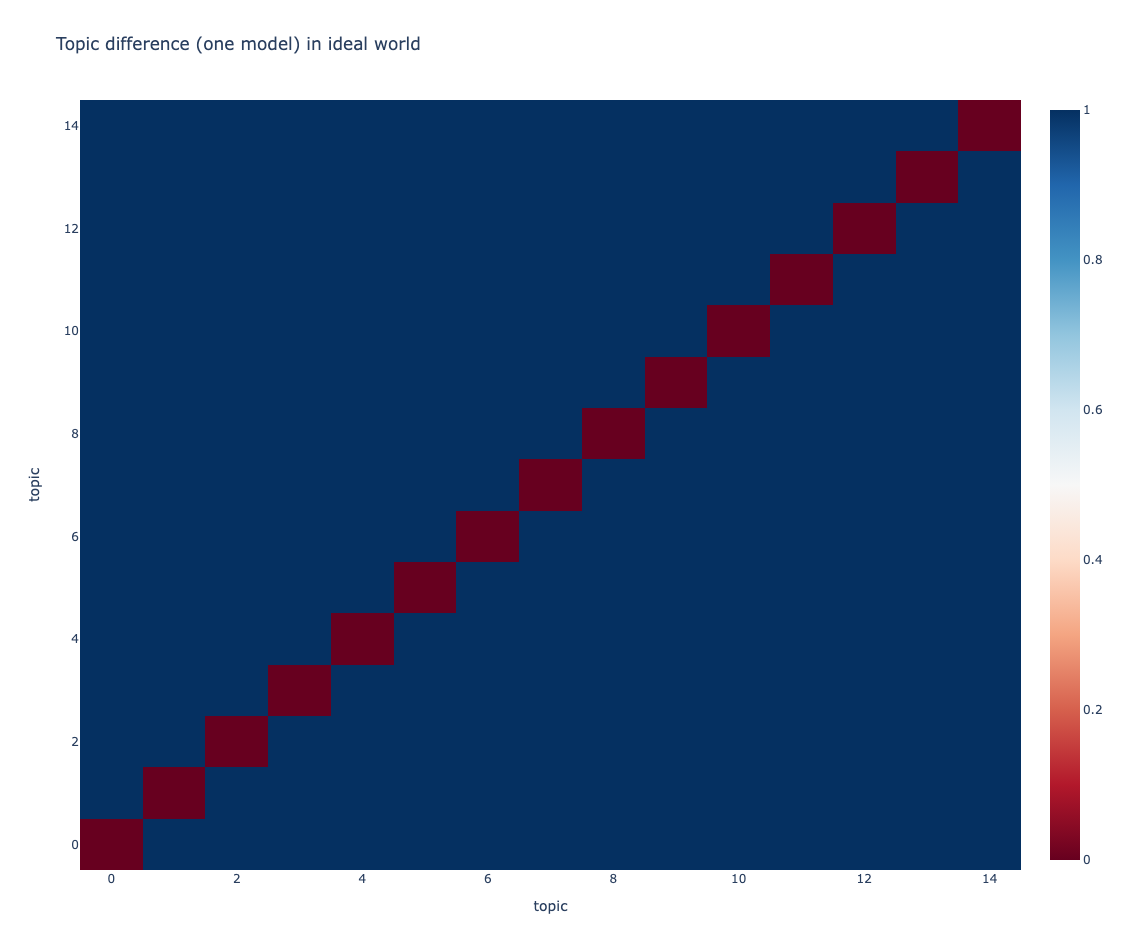

In [25]:
plot_difference(mdiff, title="Topic difference (one model) in ideal world")

Unfortunately, in real life, not everything is so good, and the matrix looks different.

Short description (interactive annotations only):

* ``+++ make, world, well`` - words from the intersection of topics = present in both topics;
* ``--- money, day, still`` - words from the symmetric difference of topics = present in one topic but not the other.




In [26]:
mdiff, annotation = lda_fst.diff(lda_fst, distance='jaccard', num_words=50)

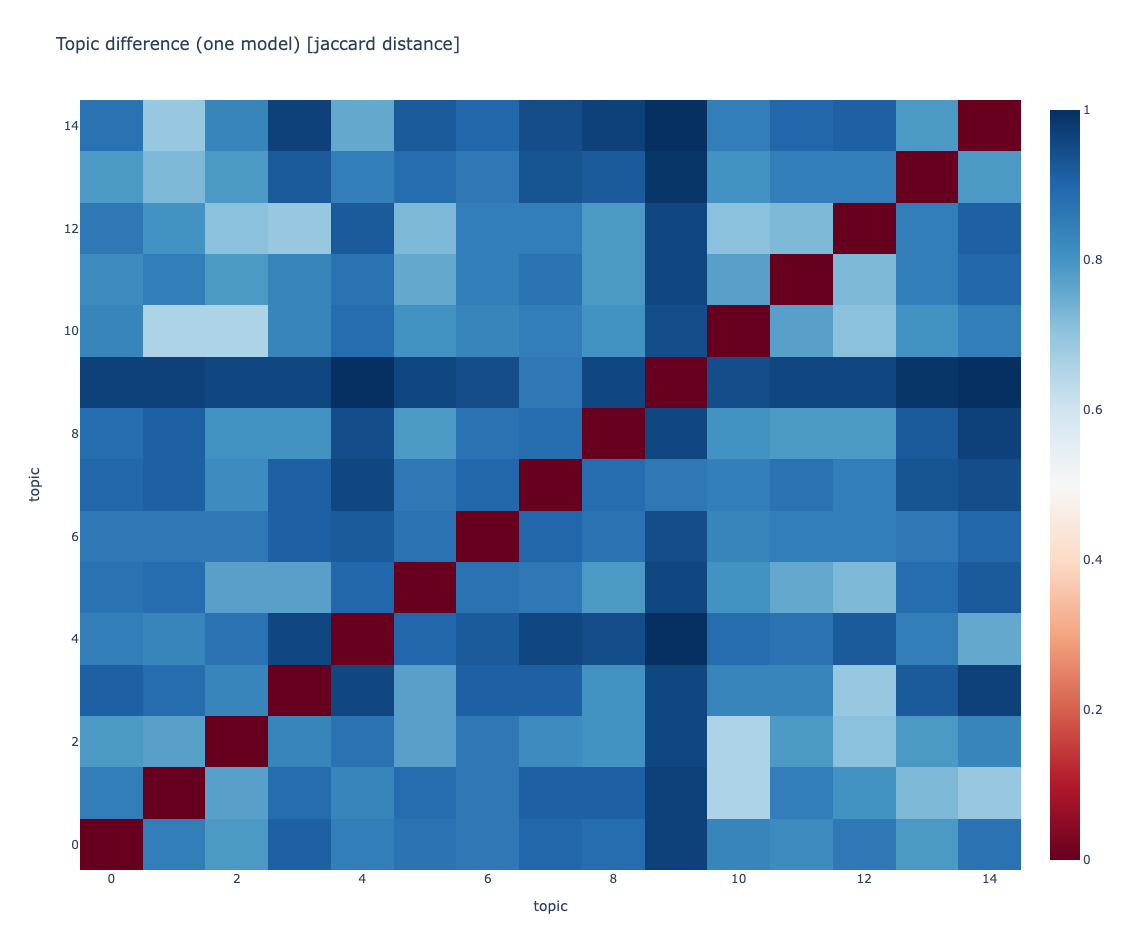

In [27]:
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

If you compare a model with itself, you want to see as many red elements as
possible (except on the diagonal). With this picture, you can look at the
"not very red elements" and understand which topics in the model are very
similar and why (you can read annotation if you move your pointer to cell).

Jaccard is a stable and robust distance function, but sometimes not sensitive
enough. Let's try to use the Hellinger distance instead.




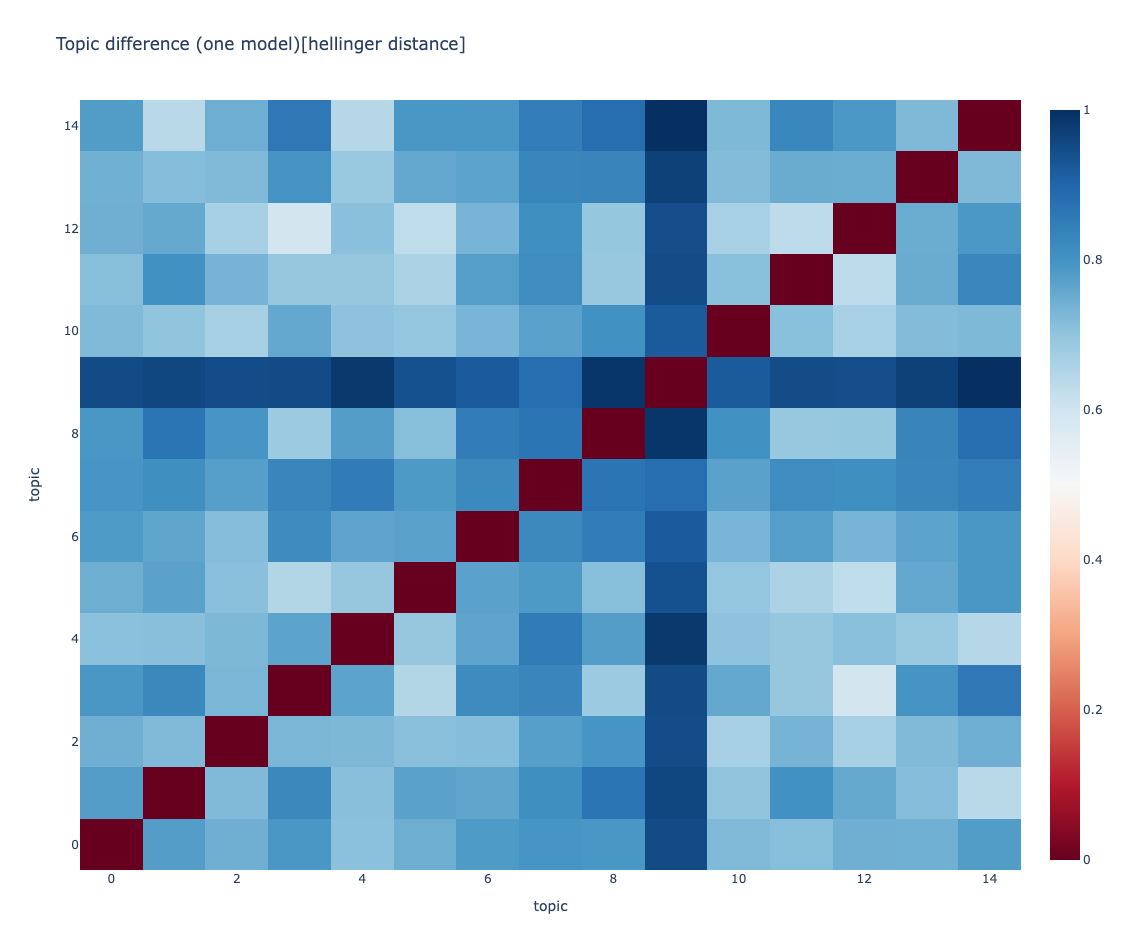

In [28]:
mdiff, annotation = lda_fst.diff(lda_fst, distance='hellinger', num_words=50)
plot_difference(mdiff, title="Topic difference (one model)[hellinger distance]", annotation=annotation)

You see that everything has become worse, but remember that everything depends on the task.

Choose a distance function that matches your upstream task better: what kind of "similarity" is
relevant to you. From my (Ivan's) experience, Jaccard is fine.




## Case 2: How topics from DIFFERENT models correlate with each other.

Sometimes, we want to look at the patterns between two different models and compare them.

You can do this by constructing a matrix with the difference.




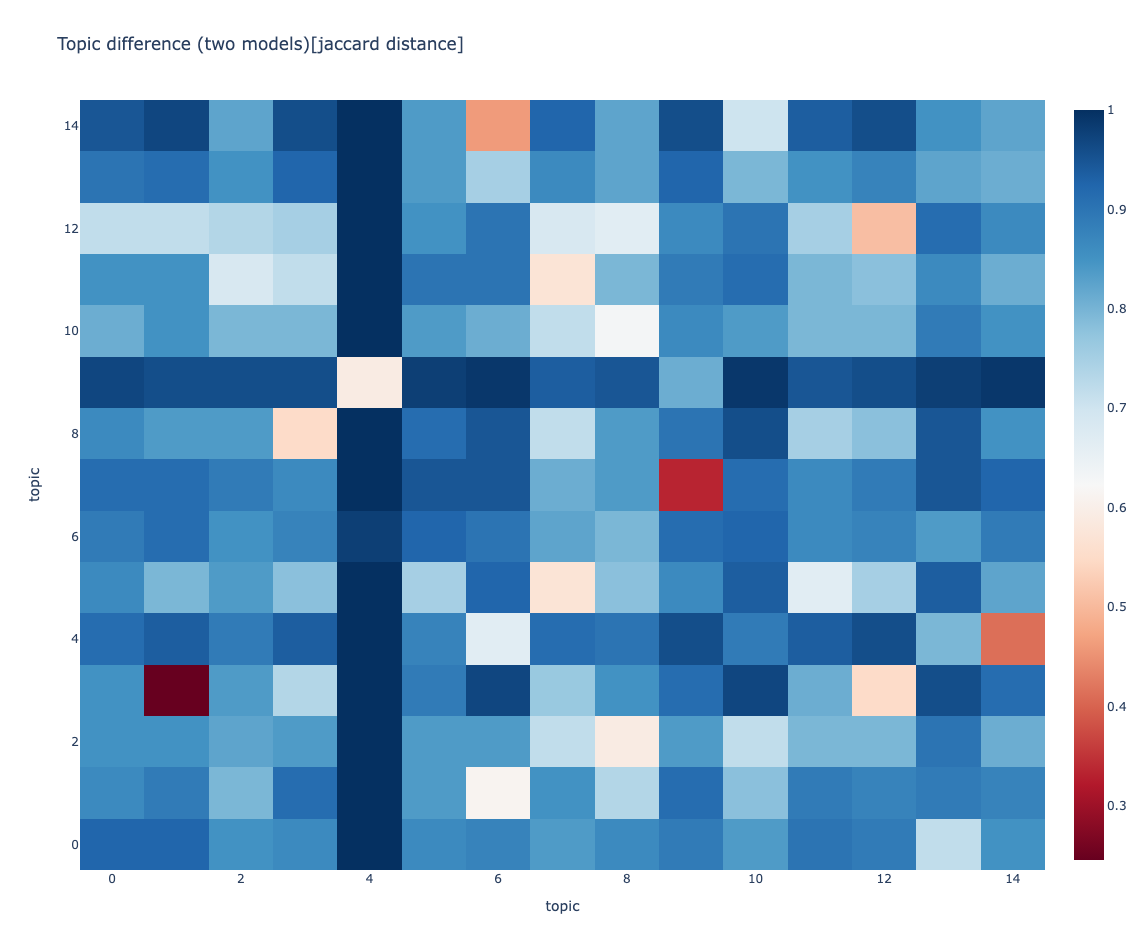

In [29]:
mdiff, annotation = lda_fst.diff(lda_snd, distance='jaccard', num_words=50)
plot_difference(mdiff, title="Topic difference (two models)[jaccard distance]", annotation=annotation)

Looking at this matrix, you can find similar and different topics between the two models.
The plot also includes relevant tokens describing the topics' intersection and difference.


